# Importing Libraries

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    PolynomialFeatures, 
    LabelEncoder,
    StandardScaler, 
    MinMaxScaler, 
    OneHotEncoder, 
    KBinsDiscretizer
)
from sklearn.linear_model import (
    LinearRegression, 
    LogisticRegression,
    Ridge, 
    Lasso
)
from sklearn.tree import (
    DecisionTreeRegressor,
    DecisionTreeClassifier
)
from sklearn.ensemble import (
    RandomForestRegressor,
    RandomForestClassifier,
)   
from sklearn.model_selection import (
    train_test_split,
    cross_val_predict,
    GridSearchCV,
)
from sklearn.metrics import (
    mean_absolute_percentage_error,
    mean_absolute_error, 
    mean_squared_error, 
    r2_score, 
    confusion_matrix, 
    accuracy_score, 
    classification_report,
    recall_score,
    precision_score
)


from scripts.clean_dataset import clean_dataset
from scripts.helper import currency, cal_accuracy


# Importing the cleaned dataset

In [2]:
df_train = pd.read_csv('data/Train_cleaned.csv')
#df_train = pd.read_csv('data/Train_cleaned_log_transformed.csv')
#df_test  = pd.read_csv('data/Test.csv')
#df_test  = clean_dataset(df_test)

In [3]:
df_train.shape

(3099, 27)

## Categorization of total_cost (manually)

In [4]:
#bin_edges  = [0, 500, 1500, 5000, float('inf')]
#bin_labels = ['Low', 'Medium', 'High', 'Very High']

# Create a new column 'cost_category' based on the binning
#df_train['total_cost_category'] = pd.cut(
#    df_train['total_cost_euro'], 
#    bins=bin_edges, 
#    labels=bin_labels, 
#    right=False,
#    include_lowest=True,
#)

## Categorization of total_cost (using KBins)

In [5]:
kbins = KBinsDiscretizer(
    n_bins=5,
    encode='onehot-dense', # onehot, onehoe-dense, ordinal
    strategy='quantile',   # kmeans, uniform, quantile
)
bin_data  = kbins.fit_transform(df_train[['total_cost_euro']])
bin_names = ['very low', 'low', 'medium', 'high', 'very high']
bin_edges = kbins.bin_edges_[0].round()

# Apply pd.cut with custom bin edges to start the first bin at zero
bin_edges = np.concatenate(([0], bin_edges[1:]))

df_train['total_cost_category'] = pd.cut(
    df_train['total_cost_euro'], 
    bins=bin_edges, 
    labels=bin_names, 
    include_lowest=True,
)

In [6]:
# show the bins
for i in range(len(bin_names)):
    print(bin_names[i].ljust(10), f"{currency(bin_edges[i])} - {currency(bin_edges[i+1])}".center(30))

very low         0.00 € - 208.00 €       
low             208.00 € - 708.00 €      
medium         708.00 € - 1,976.00 €     
high          1,976.00 € - 4,537.00 €    
very high     4,537.00 € - 36,330.00 €   


# Target and Features

In [7]:
# Target:
y = df_train['total_cost_category']
# Features:
X = df_train.drop([
    'total_cost', 'total_cost_euro', 'total_cost_category', 
], axis=1)

## Seperate numerical and categorical features

In [9]:
num_features = list(X.select_dtypes(include=['number']).columns)
cat_features = list(X.select_dtypes(include=['object']).columns)

In [13]:
cat_features = list(set(cat_features) - set(['info_source', 'payment_mode', 'most_impressing']))
num_features = ['total_travelers', 'night_total', 'total_female']

In [ ]:
#num_features = ['total_travelers', 'night_total', 'total_female']
#cat_features = ['country', 'age_group', 'travel_with', 'main_activity', 'tour_arrangement', 'purpose']

In [14]:
cat_features, num_features

(['tour_arrangement',
  'purpose',
  'age_group',
  'country',
  'main_activity',
  'travel_with'],
 ['total_travelers', 'night_total', 'total_female'])

# Splitting the dataset

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)#, random_state=47)

# Baseline Model

Given our target variable ('total_cost') is a continuous variable, this is a regression problem. 

In [17]:
print('Mean:  ', currency(df_train.total_cost_euro.mean()))
print('Median:', currency(df_train.total_cost_euro.median()))

Mean:   2,958.33 €
Median: 1,209.97 €


In [18]:
df_train.total_cost_euro.describe().apply(lambda x: currency(x))

count     3,099.00 €
mean      2,958.33 €
std       4,396.78 €
min          17.88 €
25%         302.49 €
50%       1,209.97 €
75%       3,629.92 €
max      36,329.50 €
Name: total_cost_euro, dtype: object

# Create a pipeline

## Building the pipeline

In [38]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler',  StandardScaler()),
    ('poly',    PolynomialFeatures(degree=10))
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers into a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features),
])

# Create a Logistic Regression pipeline
estimator = Pipeline(steps=[
    ('preprocessor', preprocessor),
   # ('classifier',   LogisticRegression(max_iter=10_000, class_weight="balanced"))
    ('classifier',   RandomForestClassifier())
#    ('classifier', Ridge(alpha=0.5)),
#    ('classifier', DecisionTreeClassifier())

])

estimator.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=10))]),
                                                  ['total_travelers',
                                                   'night_total',
                                                   'total_female']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['tour_arrangement',
                                                   'purpose', 'age_group',
                                                   'country', 'main_activity',
                                                   'travel_with'])])),
                ('classifier', RandomForestClassifier())])

## Predicting

In [39]:
# Predict for training and test sets
y_pred_train = estimator.predict(X_train)
y_pred_test  = estimator.predict(X_test)

## Evaluation

### Training set evaluation

Accuracy on train set: 0.92
Accuracy on train set: 0.92
              precision    recall  f1-score   support

        high       0.92      0.90      0.91       494
         low       0.94      0.89      0.92       499
      medium       0.93      0.91      0.92       494
   very high       0.89      0.95      0.92       498
    very low       0.92      0.94      0.93       494

    accuracy                           0.92      2479
   macro avg       0.92      0.92      0.92      2479
weighted avg       0.92      0.92      0.92      2479



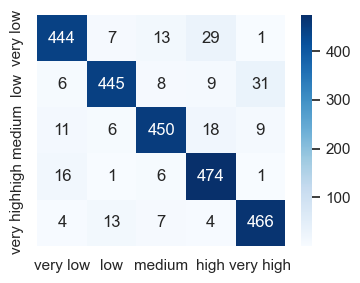

In [36]:
train_score  = estimator.score(X_train, y_train)
print("Accuracy on train set:", round(train_score, 2))
print("Accuracy on train set:", round(accuracy_score(y_train, y_pred_train), 2))
print(classification_report(y_train, y_pred_train))
cf_train = confusion_matrix(y_train, y_pred_train)
sns.set(rc={"figure.figsize":(4, 3)})
sns.heatmap(cf_train, annot=True, fmt="", cmap='Blues', xticklabels=bin_names, yticklabels=bin_names);

### Test set evaluation

Accuracy on test set: 0.46
Accuracy on test set: 0.46
              precision    recall  f1-score   support

        high       0.47      0.45      0.46       124
         low       0.35      0.26      0.30       125
      medium       0.39      0.38      0.39       123
   very high       0.56      0.67      0.61       124
    very low       0.48      0.54      0.51       124

    accuracy                           0.46       620
   macro avg       0.45      0.46      0.45       620
weighted avg       0.45      0.46      0.45       620



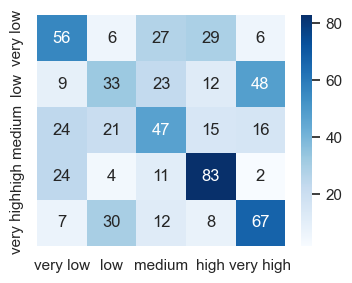

In [35]:
test_score   = estimator.score(X_test,  y_test)
print("Accuracy on test set:",  round(test_score, 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred_test), 2))
print(classification_report(y_test, y_pred_test))

cf_test = confusion_matrix(y_test, y_pred_test)
sns.set(rc={"figure.figsize":(4, 3)})
sns.heatmap(cf_test, annot=True, fmt="", cmap='Blues', xticklabels=bin_names, yticklabels=bin_names);

In [27]:
# The evaluation metric for this competition is Mean Absolute Error.

#mean_absolute_error(y_train, y_pred_train)

## Cross Validation

In [28]:
y_pred_test_cv = cross_val_predict(estimator, X_test, y_test, cv=4)

In [29]:
cv_score = estimator.score(X_test, y_pred_test_cv)
print("Cross validation scores:", round(cv_score, 2))
print(classification_report(y_test, y_pred_test_cv))

Cross validation scores: 0.47
              precision    recall  f1-score   support

        high       0.40      0.45      0.42       124
         low       0.39      0.34      0.36       125
      medium       0.37      0.35      0.36       123
   very high       0.50      0.53      0.51       124
    very low       0.46      0.45      0.45       124

    accuracy                           0.42       620
   macro avg       0.42      0.42      0.42       620
weighted avg       0.42      0.42      0.42       620



# Saving the model

In [ ]:
from scripts.model_serializer import ModelSerializer
model = estimator
savegame = ModelSerializer('models/best_model.sav')
savegame.dump(model)

# Loading the model

In [ ]:
savegame = ModelSerializer('models/best_model.sav')
model = savegame.load()
model

# Grid Search

In [ ]:



# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [ ]:
# Define a parameter grid for GridSearchCV
param_grid = {
    'classifier': [
        LogisticRegression(max_iter=10_000),
        Ridge(alpha=0.5),
#        DecisionTreeClassifier(),
#        RandomForestClassifier(),
#        XGBRegressor(),
    ],
}

# Create GridSearchCV,
grid_search = GridSearchCV(
    estimator,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error', #'r2', 
    verbose=1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions\n",
y_pred_train = best_model.predict(X_train)
y_pred_test  = best_model.predict(X_test)

In [ ]:
# Evaluate the best model
print('Best Model:', best_model.named_steps['classifier'])
print('Mean Absolute Percentage Error:', round(mean_absolute_percentage_error(y_train, y_pred_train), 2))
print('Mean Absolute Error:', round(np.sqrt(mean_absolute_error(y_test, y_pred_test)), 2))
print('Mean Squared Error:', round(np.sqrt(mean_squared_error(y_test, y_pred_test)), 2))
print('R-squared:', round(r2_score(y_test, y_pred_test), 2))








def coeff_info(model):
    coeff_used = np.sum(model.coef_!=0)
    print('The model is using', coeff_used, 'out of 66 features.')
    print( "The highest coefficient has a value of:", max(model.coef_.round(3)))

    
#coeff_info(best_model)

In [ ]:
def error_analysis(y_test, y_pred_test):
    """Generated true vs. predicted values and residual scatter plot for models

    Args:
        y_test (array): true values for y_test
        y_pred_test (array): predicted values of model for y_test
    """     
    # Calculate residuals
    residuals = y_test - y_pred_test
    
    # Plot real vs. predicted values 
    fig, ax = plt.subplots(1,2, figsize=(15, 5))
    plt.subplots_adjust(right=1)
    plt.suptitle('Error Analysis')
    
    ax[0].scatter(y_pred_test, y_test, color="#FF5A36", alpha=0.7)
    ax[0].plot([-400, 350], [-400, 350], color="#193251")
    ax[0].set_title("True vs. predicted values", fontsize=16)
    ax[0].set_xlabel("predicted values")
    ax[0].set_ylabel("true values")
    ax[0].set_xlim((y_pred_test.min()-10), (y_pred_test.max()+10))
    ax[0].set_ylim((y_test.min()-40), (y_test.max()+40))
    
    ax[1].scatter(y_pred_test, residuals, color="#FF5A36", alpha=0.7)
    ax[1].plot([-400, 350], [0,0], color="#193251")
    ax[1].set_title("Residual Scatter Plot", fontsize=16)
    ax[1].set_xlabel("predicted values")
    ax[1].set_ylabel("residuals")
    ax[1].set_xlim((y_pred_test.min()-10), (y_pred_test.max()+10))
    ax[1].set_ylim((residuals.min()-10), (residuals.max()+10))
    
error_analysis(y_test, y_pred_test)

In [ ]:

# Plotting the results
plt.figure(figsize=(8, 6))

# Scatter plot of true vs. predicted values
plt.scatter(y_test, y_pred_test, color='blue', label='Actual vs. Predicted')

# Plot the identity line (y = x)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Identity Line')

plt.title('Regression Model: Actual vs. Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()